In [51]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.decomposition import PCA
from pympler.asizeof import asizeof

In [52]:
def pca_compression(data, threshold):
    # extracts rgb channels
    channels = tuple(data[:, :, i] for i in range(data.shape[2]))
    # selects n values resulting in accumulated_variance_ratio_ >= threshold for each channel
    channels_n_components = tuple(np.argwhere(np.cumsum(
        PCA().fit(ch).explained_variance_ratio_) >= threshold)[0, 0] + 1 for ch in channels)
    # creates PCA model for each channel
    pcas = tuple(PCA(channels_n_components[i]).fit(ch)
                 for i, ch in enumerate(channels))
    # returns compressed data and decryption key
    return tuple(pca.transform(channels[i]) for i, pca in enumerate(pcas)), pcas

In [100]:
def main(image, threshold=.9):
    # Compress image and send it
    compressed_image, pcas = pca_compression(image, threshold)
    # compressed_image, pcas = pca_compression(image_normalized, threshold)
    components = [pca.get_params()['n_components'] for pca in pcas]

    # Receiver Decompresses the image
    decompressed_image = np.empty(image.shape, np.uint8)
    decompressed_image[:, :, 0], decompressed_image[:, :, 1], decompressed_image[:, :, 2] = (np.array(
        [pca.inverse_transform(compressed_image[i]) for i, pca in enumerate(pcas)])  * 255).clip(0,255)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle('Image Compression using PCA')
    axes[0].set_title(f'Original Image\nBytes: {asizeof(image)}, Dim: {image.shape[:2]}')
    axes[0].axis('off')
    axes[0].imshow(image)
    axes[1].set_title(f'Decompressed Image\nTransferred Bytes: {asizeof(compressed_image)}\nComponents: {components}')
    axes[1].axis('off')
    axes[1].imshow(decompressed_image)
    plt.tight_layout()
    plt.show()

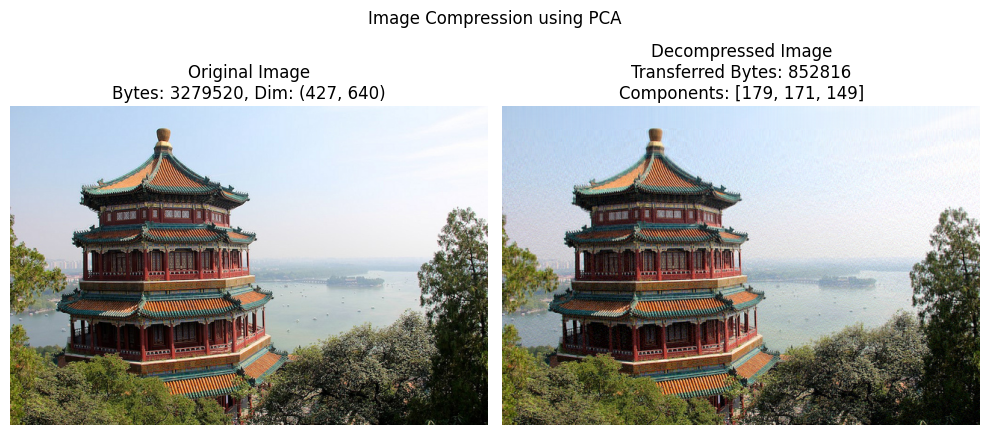

In [101]:
image = imread('china-original.png')
main(image, .99)

### It is observed that we can reduce image's size by ~75% through capturing 99% of image's variance without major quality loss in this example.